In [1]:
%config InlineBackend.figure_format = 'retina'

import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from pathlib import Path
from collections import namedtuple

import numpy as np
import pandas as pd

from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy import units as u
from astropy.time import Time
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS

import lsst.afw.image as afwImage
from lsst.afw import cameraGeom

from lsst.geom import Point2D
from lsst.daf.butler import Butler

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
class VisitID(namedtuple('VisitID', 'day_obs, seq_num, detector, psf, ccd_coordinates')):
    __slots__ = ()
    @property
    def visit_id(self):
        return int(f'{self.day_obs}{self.seq_num:05d}') 
    
exposure_list = [
    VisitID(20241129, 236, 7, 1.3, (3310, 260)),
    VisitID(20241129, 237, 7, 1.39, (3925, 1030)),
    VisitID(20241129, 238, 8, 1.25, (535, 2070)),
    VisitID(20241129, 239, 8, 1.37, (1300, 3000)),
    VisitID(20241129, 240, 8, 1.41, (1950, 3820)),
    VisitID(20241129, 246, 4, 1.33, (2800, 3850)),
    VisitID(20241129, 247, 7, 1.36, (3650, 690)),
    VisitID(20241129, 248, 8, 1.36, (200, 1650)),
    VisitID(20241129, 249, 8, 1.34, (940, 2570)),
    VisitID(20241129, 250, 8, 1.40, (1660, 3490)),
    VisitID(20241207, 549, 7, 2.83, (3935, 1470)),
    VisitID(20241207, 550, 8, 2.86, (410, 2350))
]

# Get hand scanned satellite data from processed fits files

satellite_data = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRs-6gh1dIAjqTUdN-UOpQmaohx1U3ecO8vrb2EHUbBkoPeV14XWbtPW60-vy7cQt1Wcf1022tSo61J/pub?gid=1240073687&single=true&output=csv'
satellite_df = pd.read_csv(satellite_data)
satellite_df = satellite_df.set_index(['obsid', 'satellite'])

satellite_df = satellite_df.drop('Notes', axis=1)
# satellite_df = satellite_df.dropna(how='all')
satellite_df

,,RA_Start,DEC_Start,Error_Start,RA_End,DEC_End,Error_End,Shutter_offset,Blade
obsid,satellite,,,,,,,,
CC_O_20241129_000236_R22_S21,EUTE 117W B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_O_20241129_000237_R22_S21,EUTE 117W B,35.166472,4.626702,0.522,NaN,NaN,NaN,22.0,B
CC_O_20241129_000238_R22_S22,EUTE 117W B,35.232824,4.626801,0.347,NaN,NaN,NaN,33.0,A
CC_O_20241129_000239_R22_S22,EUTE 117W B,35.299805,4.626900,0.581,NaN,NaN,NaN,21.0,B
CC_O_20241129_000240_R22_S22,EUTE 117W B,35.365886,4.627031,0.506,NaN,NaN,NaN,34.0,A
CC_O_20241129_000246_R22_S11,EUTE 117W B,35.971827,4.627898,0.364,NaN,NaN,NaN,30.0,A
CC_O_20241129_000247_R22_S21,EUTE 117W B,36.038466,4.627908,0.514,NaN,NaN,NaN,26.0,B
CC_O_20241129_000248_R22_S22,EUTE 117W B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_O_20241129_000249_R22_S22,EUTE 117W B,36.171805,4.628094,0.592,NaN,NaN,NaN,19.0,B


In [3]:
%%script echo Skip Cell

filename = '/sdf/home/c/cwalter/test-fits/CC_O_20241129_000237_R22_S21.fits'
with fits.open(filename) as hdu_list: 
        
        header_wcs = WCS(hdu_list[1])
        print(header_wcs)
        
        sat_ra, sat_dec = 35.1664715,  4.6267015

        key = 'CC_O_20241129_000237_R22_S21'
        sat_entry = satellite_df.loc[key]
        sat_ra, sat_dec = sat_entry.RA_Start.iloc[0], sat_entry.DEC_Start.iloc[0]

        sat_coor = SkyCoord(sat_ra, sat_dec, unit=(u.deg, u.deg),frame='icrs')
        header_pixels = header_wcs.world_to_pixel(sat_coor)
        
        print('\n')
        print(sat_ra, sat_dec)
        print(header_pixels)
        
        exposure = afwImage.ExposureF.readFits(filename)
        exposure_wcs = exposure.getWcs()
        sky = exposure_wcs.pixelToSky(header_pixels[0], header_pixels[1])
        print(sky)

Skip Cell


In [4]:
raft_side  = 123.38 # mm
aperture_side = 236.0 # mm

blade_array = []
shutter_array = []
x_array = []
y_array = []

for entry in sorted(os.scandir('/sdf/home/c/cwalter/test-fits'), key=lambda x: x.name):
    with fits.open(entry.path) as hdu_list: 
        
        obs_id = Path(entry.name).stem
        header_wcs = WCS(hdu_list[1])
        
        key = obs_id
        sat_entry = satellite_df.loc[key]
        sat_ra, sat_dec, blade = sat_entry.RA_Start.iloc[0], sat_entry.DEC_Start.iloc[0], sat_entry.Blade.iloc[0]
        
        if not math.isnan(sat_ra):

            sat_coor = SkyCoord(sat_ra, sat_dec, unit=(u.deg, u.deg),frame='icrs')
            header_pixels = header_wcs.world_to_pixel(sat_coor)
            x,y  = header_pixels[0], header_pixels[1]

            exposure = afwImage.ExposureF.readFits(entry.path)
            exposure_wcs = exposure.getWcs() # not using right now

            detector = exposure.getDetector()

            detector_pixels = np.vstack((x, y))
            pixel_to_focalplane_transform = detector.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
            focal_plane_x, focal_plane_y = pixel_to_focalplane_transform.getMapping().applyForward(detector_pixels)

            # Calculate the shutter time delta
            E = aperture_side/2 
            x = focal_plane_x[0] # mm
            y = focal_plane_y[0] # mm
            delta_S = 396 # milliseconds

            if blade == 'A':
                shutter_time = (E - x) * delta_S/(2*E)
            elif blade == 'B':
                shutter_time = (E + x) * delta_S/(2*E)

            blade_array.append(blade)
            x_array.append(focal_plane_x[0])
            y_array.append(focal_plane_y[0])
            shutter_array.append(shutter_time)
            
            print (f'{obs_id}, {detector.getName()}, {detector.getId()}, {blade}, {focal_plane_x[0]:3.6f}, {focal_plane_y[0]:3.6f}, {shutter_time:7.6f}')

        else:
            print('Skipping')
            

Skipping
CC_O_20241129_000237_R22_S21, R22_S21, 7, B, 17.527730, 30.855887, 227.410937
CC_O_20241129_000238_R22_S22, R22_S22, 8, A, 24.985221, 40.106897, 156.075646
CC_O_20241129_000239_R22_S22, R22_S22, 8, B, 32.492810, 49.453482, 252.521833
CC_O_20241129_000240_R22_S22, R22_S22, 8, A, 39.909621, 58.651111, 131.033008
CC_O_20241129_000246_R22_S11, R22_S11, 4, A, 6.411965, 17.042216, 187.240940
CC_O_20241129_000247_R22_S21, R22_S21, 7, B, 13.858358, 26.319919, 221.253855
Skipping
CC_O_20241129_000249_R22_S22, R22_S22, 8, B, 28.828102, 44.908100, 246.372579
CC_O_20241129_000250_R22_S22, R22_S22, 8, A, 36.256282, 54.149963, 137.163189
CC_O_20241207_000549_R22_S21, R22_S21, 7, A, 17.233038, 34.857633, 169.083547
CC_O_20241207_000550_R22_S22, R22_S22, 8, B, 23.592674, 42.792849, 237.587708


In [5]:
x_1129 = x_array[:-2]
y_1129 = y_array[:-2]

x_1207 = x_array[-2:]
y_1207 = y_array[-2:]

shutter_1129 = shutter_array[:-2]
shutter_1207 = shutter_array[-2:]

#x_1129 = [17.527730, 24.985221, 32.492810, 39.909621, 6.411965, 13.858358, 28.828102, 36.256282]
#y_1129 = [30.855887, 40.106897, 49.453482, 58.651111, 17.042216, 26.319919, 44.908100, 54.149963]
#x_1207 = [17.233038, 23.592674]
#y_1207=[34.857633, 42.792849]

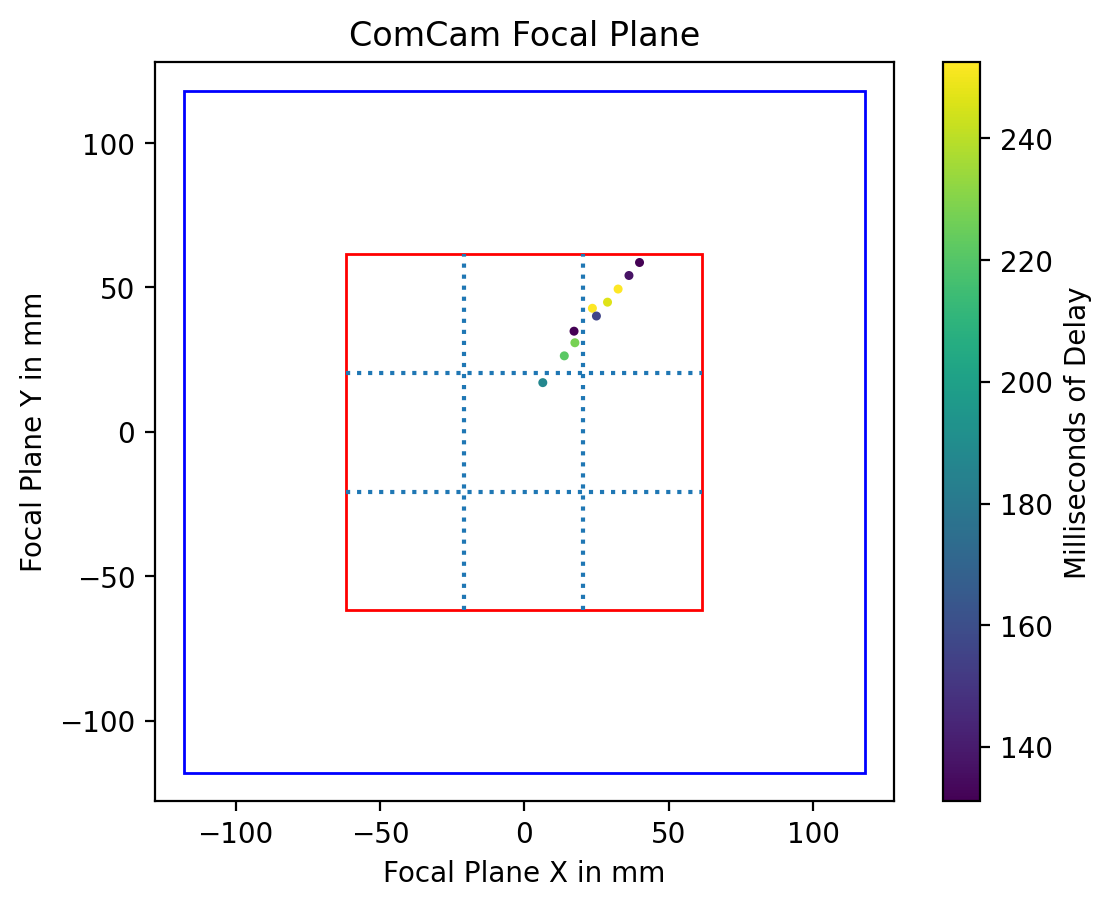

In [6]:

plt.scatter(x_1207, y_1207, s=5, c=shutter_1207)
plt.scatter(x_1129, y_1129, s=5, c=shutter_1129)

raft = Rectangle((-raft_side/2, -raft_side/2), raft_side, raft_side, edgecolor='r',facecolor='none')
aperture = Rectangle((-aperture_side/2, -aperture_side/2), aperture_side, aperture_side, edgecolor='b',facecolor='none')

plt.vlines(-raft_side/2 + 40.96, -raft_side/2, raft_side/2, linestyles='dotted')
plt.vlines(-raft_side/2 + 40.96 + 0.25 + 40.96 , -raft_side/2, raft_side/2, linestyles='dotted' )

plt.hlines(-raft_side/2 + 40.96, -raft_side/2, raft_side/2, linestyles='dotted')
plt.hlines(-raft_side/2 + 40.96 + 0.25 + 40.96 , -raft_side/2, raft_side/2, linestyles='dotted' )

plt.gca().add_patch(aperture)
plt.gca().add_patch(raft)

plt.gca().set_aspect('equal')
plt.xlim(-aperture_side/2 - 10, aperture_side/2 + 10)
plt.ylim(-aperture_side/2 - 10, aperture_side/2 + 10)

plt.title('ComCam Focal Plane')
plt.xlabel('Focal Plane X in mm')
plt.ylabel('Focal Plane Y in mm')

plt.colorbar(label='Milliseconds of Delay')

In [7]:
(118 -23 ) / (2*118) * 394

158.60169491525423

In [8]:
394/2

197.0

In [10]:
np_shutter = np.array(shutter_array)
np_shutter.mean(), np_shutter.std()

(196.57432423198253, 43.772603817871925)

In [11]:
(np_shutter.max() - np_shutter.min()) * 0.015

1.8223323724858949

In [22]:
df = pd.DataFrame({'blade':blade_array, 'shutter_time':shutter_array, 'x':x_array, 'y':y_array})
sorted = df.sort_values(['blade','x'])
sorted

,blade,shutter_time,x,y
4,A,187.240940,6.411965,17.042216
8,A,169.083547,17.233038,34.857633
1,A,156.075646,24.985221,40.106897
7,A,137.163189,36.256282,54.149963
3,A,131.033008,39.909621,58.651111
5,B,221.253855,13.858358,26.319919
0,B,227.410937,17.527730,30.855887
9,B,237.587708,23.592674,42.792849
6,B,246.372579,28.828102,44.908100
2,B,252.521833,32.492810,49.453482


Text(0, 0.5, 'Milliseconds of Delay')

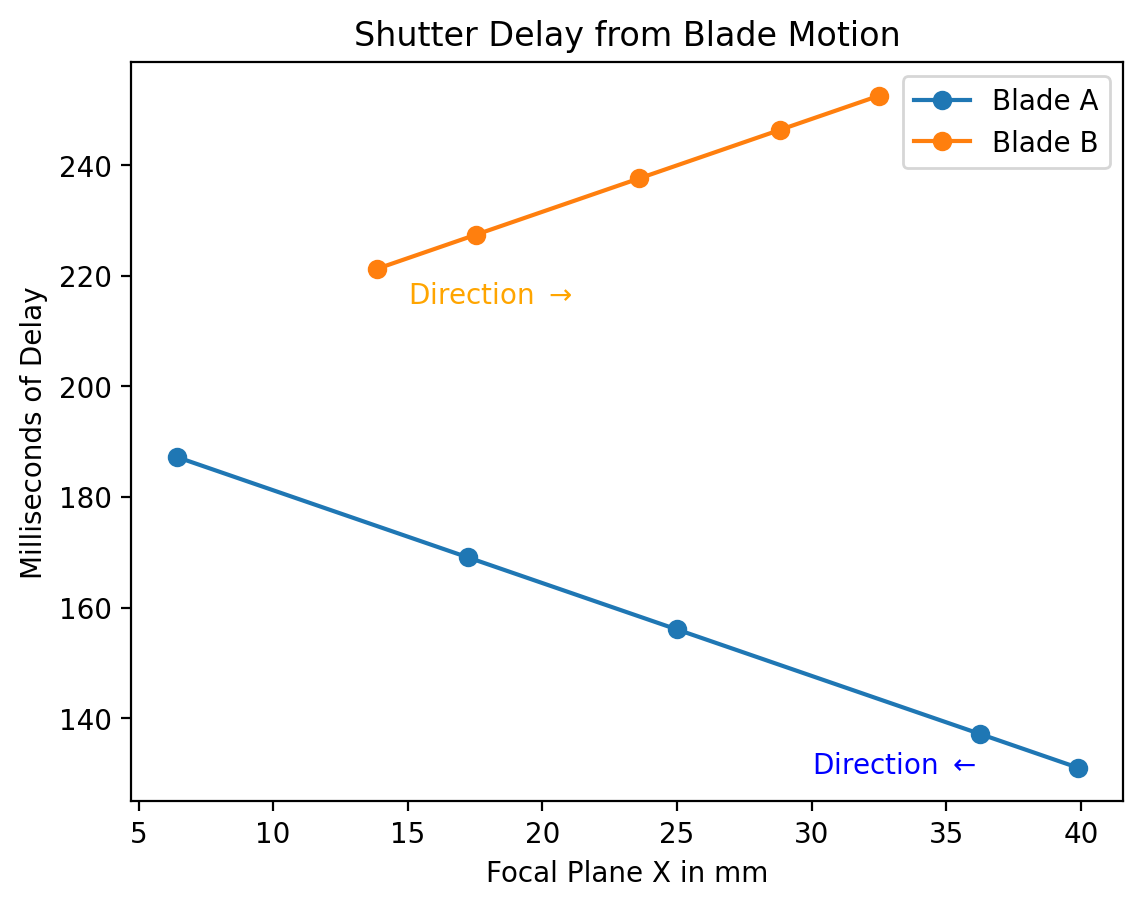

In [52]:
ax1 = sorted.query("blade == 'A'").plot('x', 'shutter_time', style='o-', label='Blade A')
sorted.query("blade == 'B'").plot('x', 'shutter_time', ax=ax1, style='o-', label='Blade B')

plt.text(30, 130, r'Direction $\leftarrow$', color='blue')
plt.text(15, 215, r'Direction $\rightarrow$', color='orange')

plt.title('Shutter Delay from Blade Motion')
plt.xlabel('Focal Plane X in mm')
plt.ylabel('Milliseconds of Delay')